<a href="https://colab.research.google.com/github/SamuelBFG/ga-fading/blob/main/AIC_working_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from scipy import special as sp
from scipy.stats import gaussian_kde
from scipy.io import loadmat
from sklearn.neighbors import KernelDensity
from scipy import special as sp

plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

## Set up directories
paths = ['plots', 
            'plots/gen/', 
        ]
for i in paths:
    if not os.path.exists(i):
        os.makedirs(i)

In [29]:
data_dBm = pd.read_csv('/content/P_dBm_out_LOS_Head_Indoor.txt', sep=" ", header=None).transpose().dropna().reset_index(drop=True)

In [30]:
data_dBm.describe()

,0
count,181144.000000
mean,-59.800541
std,6.614254
min,-101.912900
25%,-63.651613
50%,-59.441935
75%,-55.325806
max,-43.725806


In [31]:
data_dBm

,0
0,-49.058065
1,-49.151613
2,-49.151613
3,-49.151613
4,-49.245161
...,...
181139,-62.716129
181140,-62.529032
181141,-62.716129
181142,-62.622581


## Working on implementing AIC 

In [34]:
nExtractedSamples = 81

In [32]:
def dBm2mV(dBm):
  
  mV =  np.power(10, (dBm + 46.9897)/20)
  return mV

In [33]:
data_mV = dBm2mV(data_dBm)
globalMean = data_mV.mean()
data_mV = data_mV / globalMean
data_mV

,0
0,2.649921
1,2.621534
2,2.621534
3,2.621534
4,2.593451
...,...
181139,0.549958
181140,0.561933
181141,0.549958
181142,0.555913


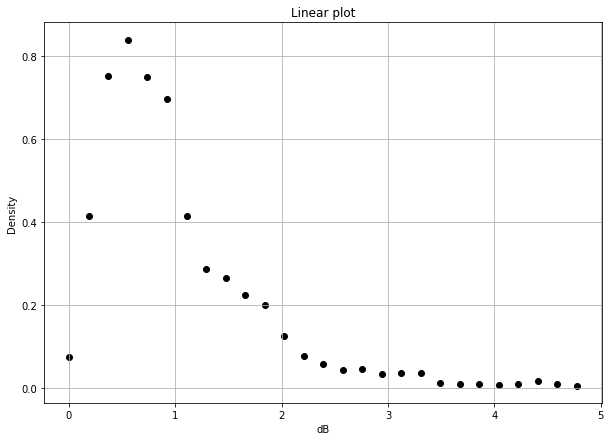

In [45]:
Xdata = np.linspace(data_mV.min(), data_mV.max(), nExtractedSamples).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.07).fit(data_mV.values.reshape(-1, 1))
logkde = kde.score_samples(Xdata)
Ydata = np.exp(logkde).reshape(-1,1)
plt.figure(figsize=(10,7))
plt.scatter(Xdata[::3], Ydata[::3], c='black')
plt.title('Linear plot')
plt.ylabel('Density')
plt.xlabel('dB')
plt.grid()
plt.show()

In [119]:
from scipy.special import gamma
import math

mle_kappa_mu = [0.0100000000000222, 0.794245863440659, 0.984845553504606]

mle_shadowed_kappa_mu = [2.50378514576399, 1.04171495240545, 1.52666133132221, 0.238939978717897]

mle_rice = [0.0260577235710763, 0.884270540895972]
rice_K = (mle_rice[0]**2) / (2*mle_rice[1]**2)
rice_omega = (mle_rice[0]**2) + (2*mle_rice[1]**2)

mle_nak = [0.631008863728655, 1.56440816925206]
nak_m = mle_nak[0]
nak_omega = mle_nak[1]

def computePDF(r, kappa, mu, omega):
  '''
  kappa-mu pdf.
  '''

  A = (2*mu * ((1 + kappa)**((mu+1)/2))) \
          /(np.sqrt(omega) * (kappa**((mu-1)/2)) * np.exp(mu * kappa))
          # /((kappa**((mu - 1)/2)) * np.exp(mu * kappa))
  # R = r / r_hat
  B = (r / np.sqrt(omega))**(mu)
  # B = (R**mu) * np.exp(- mu*(1 + kappa)*(R**2))
  C = np.exp(-mu*(1+kappa) * (r/np.sqrt(omega))**2)
  # C = sp.iv(mu - 1, 2*mu * R * np.sqrt(kappa*(1 + kappa)))
  D = sp.iv(mu-1, 2*mu * np.sqrt(kappa * (1+kappa)) * (r/np.sqrt(omega)))

  pdf = A * B * C * D
  return pdf

def shadowedKappaMuPDF(r, kappa, mu, omega, md):
  A = 2 * r**((2*mu) -1) / omega**(mu)
  B = (mu**mu * md**md * (1+kappa)**mu) / (sp.gamma(mu) * ((mu*kappa)+md)**md)
  C = np.exp((- mu * (1+kappa) * r**2) / omega)
  D = (mu**2) * kappa * (1+kappa) * (r**2)
  E = ((mu*kappa)+md) * omega
  F = sp.hyp1f1(md, mu, D / E)

  pdf = A * B * C * F
  return pdf

  A = (2 * r**((2*mu) -1) * mu**mu * md**md * (1+kappa)**mu) / \
          (gamma(mu) * ((mu*kappa)+m)**md * r_hat**(2*mu))
  B = np.exp(- mu * (1+kappa) * R**2)
  C = sp.hyp1f1(m, mu, ((mu**2 * kappa * (1+kappa))/ ((mu*kappa)+m)) * R**2)

  PDF = A * B * C 
  # A = 2 * r**(2*mu-1) / omega**mu
  # B = mu**mu * md**md * (1+kappa)**mu / gamma(mu) * (muu*kappa + md)**md
  # C = math.exp(-((mu*(1+kappa)*(r**2))/omega))
  # D = mu**2 * kappa * (1+kappa) * (r**2)
  # E = 
  # return B

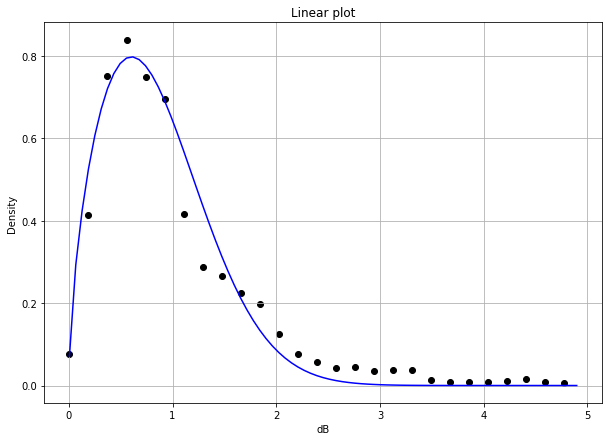

In [52]:
k_u_pdf = kappaMu_pdf(Xdata, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2])
plt.figure(figsize=(10,7))
plt.scatter(Xdata[::3], Ydata[::3], c='black')
plt.plot(Xdata, k_u_pdf, c='blue')
plt.title('Linear plot')
plt.ylabel('Density')
plt.xlabel('dB')
plt.grid()
plt.show()

In [60]:
def kldiv(pVec1, pVec2):
  '''
  Kullback-Leibler divergence.
  '''
  KL = np.sum(pVec1*(np.log2(pVec1)-np.log2(pVec2)))
  return KL

def RAD(kldiv1, kldiv2):
  '''
  Resistor-Average Distance.
  '''
  RAD = 1/(1/kldiv1+1/kldiv2)
  return RAD


def fitness(X, Y, fitnessType, kappa, mu, omega):
  '''
  Fitness function (MSE/RAD) to determine how good a given solution is.
  '''
  if fitnessType == 'MSE':
    y_pred = computePDF(X, kappa, mu, omega)
    n = len(Y)
    cost = 1/n * sum(val**2 for val in (Y-y_pred))
    return 1/cost
  elif fitnessType == 'RAD':
    pVec1 = Y/np.sum(Y)
    pVec2 = computePDF(X, kappa, mu, omega)/np.sum(computePDF(X, kappa, mu, omega))
    KLD_1 = kldiv(pVec1, pVec2)
    KLD_2 = kldiv(pVec2, pVec1)
    cost = RAD(KLD_1, KLD_2)
    return 1/cost


def geneticAlgorithm(X, Y, mleResults):
  '''
  Evolutionary Loop
  '''
  solutions = []
  bestParams = []
  bestCriteria = 0
  bestGen = 0


  # Generate solutions (chromossomes)
  for s in range(nPopulation):
    solutions.append((random.uniform(0.01, 10), # kappa
                        random.uniform(0.1, 1.0), # mu
                        random.uniform(0.1, 1.0))) # r_hat^2

  # Evolutionary Loop
  for i in range(nMaxGen):
    rankedSolutions = []	
    for s in solutions:
      rankedSolutions.append( (fitness(X, Y, fitnessType, s[0],s[1],s[2]), s) )
    rankedSolutions.sort()
    rankedSolutions.reverse()
    
    print(f'=== Generation: {i} === ')
    print(f'Fitness: {rankedSolutions[0][0]}')
    print('Best individual:')
    print(f'Kappa: {rankedSolutions[0][1][0]}')
    print(f'Mu: {rankedSolutions[0][1][1]}')
    print(f'Omega: {rankedSolutions[0][1][2]}\n')

    plt.figure(figsize=((10,7)))
    plt.plot(20*np.log10(X), computePDF(X, rankedSolutions[0][1][0], rankedSolutions[0][1][1], rankedSolutions[0][1][2]), label='Predicted')
    plt.scatter(20*np.log10(X), Y, color='m', label='Real')
    plt.plot(20*np.log10(X), computePDF(X, mleResults[0], mleResults[1], mleResults[2]), label='Nidhi\'s MLE')
    plt.title(f'=== Generation: {i} === ')
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'$\rho=r/\hat{r}$')
    plt.ylabel('pdf')
    if savePlots: 
      plt.savefig(f'plots/gen/gen_{i}.png')
    
    if showPlots:
      plt.show()
      plt.clf()
    else: 
      plt.clf()

    # Keeping track the best params and generation:
    if rankedSolutions[0][0] > bestCriteria:
      bestCriteria = rankedSolutions[0][0]
      bestGen = i
      bestParams = rankedSolutions[0][1]

    # Stop Criterion: Fitness > 150 (TRIAL AND ERROR)
    # if rankedSolutions[0][0] > 152.8:
    #   print('='*10+'\n'+'Stopped by fitness criteria!\n'+'='*10+'\n')
    #   # print('='*10)
    #   # print('Stopped by fitness criteria!')
    #   # print('='*10)
    #   print('Best Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
    #   print('Kappa: {}\nMu: {}\nOmega: {}'.format(bestParams[0],bestParams[1],bestParams[2]))
    #   break

    # Combine the best solutions and make a new solution of those combined solutions
    bestSolutions = rankedSolutions[:100]
    elements_kappa = []
    elements_mu = []
    elements_omega = [] 
    for s in bestSolutions:
      elements_kappa.append(s[1][0])
      elements_mu.append(s[1][1])
      elements_omega.append(s[1][2])

    newGen = []
    for _ in range(nPopulation):
      e1 = random.choice(elements_kappa) * random.uniform(0.975,1.025) # Mutation of 5%
      e2 = random.choice(elements_mu) * random.uniform(0.975,1.025) # Mutation of 5%
      e3 = random.choice(elements_omega) * random.uniform(0.975,1.025) # Mutation of 5%
      newGen.append((e1,e2,e3))

    solutions = newGen
    
    if i == nMaxGen-1:
      print('='*10+'\n'+'Max number of generations exceeded!\n'+'='*10+'\n')
      # print()
      # print('='*10)
      print('Best Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
      print('Kappa: {}\nMu: {}\nOmega: {}'.format(bestParams[0],bestParams[1],bestParams[2]))

      return bestParams[0],bestParams[1],bestParams[2]

In [57]:
### PARAMETERS
nMaxGen = 50
nPopulation = 1000
savePlots = True
showPlots = False
fitnessType = 'MSE'
nExtractedSamples = 81
# nAP = 'AP2'
kappa_hat, mu_hat, omega_hat = geneticAlgorithm(Xdata, Ydata, mle_kappa_mu)

=== Generation: 0 === 
Fitness: [262.09770996]
Best individual:
Kappa: 0.05761128942506233
Mu: 0.8691267878133857
Omega: 0.8518094921941632

=== Generation: 1 === 
Fitness: [323.17753156]
Best individual:
Kappa: 0.028722896912409753
Mu: 0.7960344982065077
Omega: 0.9561505836408527

=== Generation: 2 === 
Fitness: [324.88279111]
Best individual:
Kappa: 0.02899021856769452
Mu: 0.8042564549083594
Omega: 0.9692672642732715

=== Generation: 3 === 
Fitness: [325.85734827]
Best individual:
Kappa: 0.026703824506155598
Mu: 0.7952835809879808
Omega: 0.9900439543710495

=== Generation: 4 === 
Fitness: [325.96718401]
Best individual:
Kappa: 0.027997079246950548
Mu: 0.794059577809168
Omega: 0.9854653921301237

=== Generation: 5 === 
Fitness: [325.95927468]
Best individual:
Kappa: 0.028051951497994214
Mu: 0.795203731222239
Omega: 0.983585251009509

=== Generation: 6 === 
Fitness: [326.01769804]
Best individual:
Kappa: 0.025347318223983045
Mu: 0.79535509058826
Omega: 0.9840942503946946

=== Generatio

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [74]:
pVec1 = Ydata/np.sum(Ydata)
pVec2 = computePDF(Xdata, kappa_hat, mu_hat, omega_hat)/np.sum(computePDF(Xdata, kappa_hat, mu_hat, omega_hat))


KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)

print('Genetic Algorithm - Resistor-Average Distance:',RAD(KLD_1, KLD_2))

Genetic Algorithm - Resistor-Average Distance: 0.06939636761607985


In [79]:
pVec1 = Ydata/np.sum(Ydata)
pVec2 = computePDF(Xdata, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2])/np.sum(computePDF(Xdata, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2]))


KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)

print('MLE - Resistor-Average Distance:',RAD(KLD_1, KLD_2))

MLE - Resistor-Average Distance: 0.06929630168711659


In [77]:
kappa_hat, mu_hat, omega_hat

(0.017169151533979955, 0.794995318645691, 0.984619043234754)

No handles with labels found to put in legend.


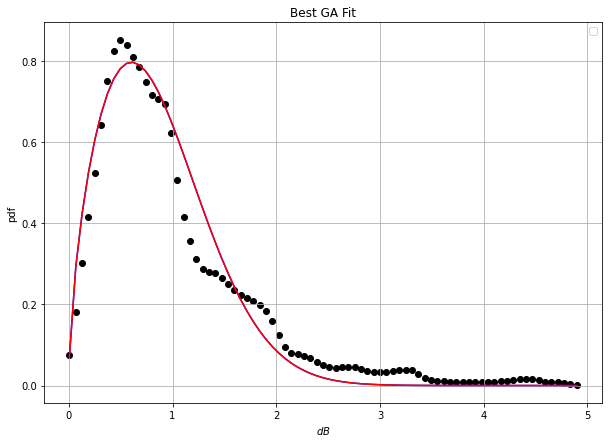

In [125]:
k_u_pdf = computePDF(Xdata, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2])
plt.figure(figsize=((10,7)))
plt.scatter(Xdata, Ydata, c='black')
plt.plot(Xdata, k_u_pdf, c='blue')
plt.plot(Xdata, computePDF(Xdata, kappa_hat, mu_hat, omega_hat), c='red')
plt.title(f'Best GA Fit')
plt.legend()
plt.grid(True)
plt.xlabel(r'$dB$')
plt.ylabel('pdf')
plt.show()

In [81]:
fitnessType = 'RAD'
# X, Y = getDensityEstimationSamples(pathAB_linear[nAP].dropna(), nExtractedSamples)
kappa_hat2, mu_hat2, omega_hat2 = geneticAlgorithm(Xdata,Ydata, mle_kappa_mu)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


=== Generation: 0 === 
Fitness: 9.73428538870852
Best individual:
Kappa: 0.2618427862900586
Mu: 0.9017870616012718
Omega: 0.8757116606927197



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


=== Generation: 1 === 
Fitness: nan
Best individual:
Kappa: 6.750174428595291
Mu: 0.9546971122734333
Omega: 0.22982875985653728

=== Generation: 2 === 
Fitness: 14.67667854802306
Best individual:
Kappa: 0.12137244994740988
Mu: 0.7083704817265304
Omega: 0.9930056517908311

=== Generation: 3 === 
Fitness: 16.39930788051153
Best individual:
Kappa: 0.08553761243662189
Mu: 0.7040548724969418
Omega: 1.0519966645527161

=== Generation: 4 === 
Fitness: 16.8004437901979
Best individual:
Kappa: 0.08472856167580727
Mu: 0.704237922112842
Omega: 1.0668315535807198

=== Generation: 5 === 
Fitness: 17.428301535637072
Best individual:
Kappa: 0.08308776314635147
Mu: 0.7342520323233322
Omega: 1.089218128592467

=== Generation: 6 === 
Fitness: 18.211650981367704
Best individual:
Kappa: 0.08347799368583252
Mu: 0.6988849048622334
Omega: 1.1251042481086158

=== Generation: 7 === 
Fitness: 18.77096180772136
Best individual:
Kappa: 0.08369596330123304
Mu: 0.7280789913207513
Omega: 1.149828259786159

=== Gener

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

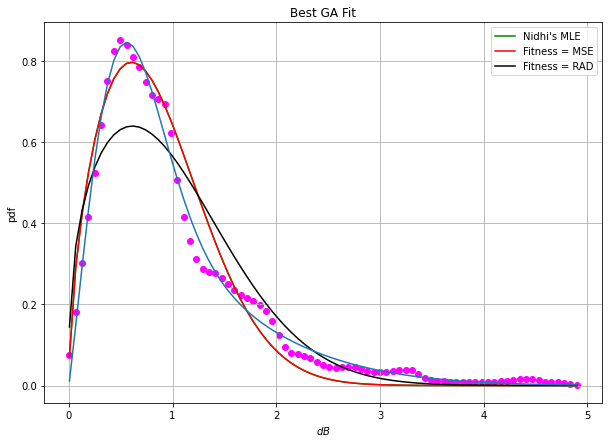

In [126]:
k_u_pdf = computePDF(Xdata, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2])
plt.figure(figsize=((10,7)))
plt.scatter(Xdata, Ydata, c='magenta')
plt.plot(Xdata, k_u_pdf, label='Nidhi\'s MLE', c='green')
plt.plot(Xdata, computePDF(Xdata, kappa_hat, mu_hat, omega_hat), label='Fitness = MSE', color='r')
plt.plot(Xdata, computePDF(Xdata, kappa_hat2, mu_hat2, omega_hat2), label='Fitness = RAD', c='black')
plt.plot(Xdata, shadowedKappaMuPDF(Xdata, mle_shadowed_kappa_mu[0], mle_shadowed_kappa_mu[1], mle_shadowed_kappa_mu[2], mle_shadowed_kappa_mu[3]))
plt.title(f'Best GA Fit')
plt.legend()
plt.grid(True)
plt.xlabel(r'$dB$')
plt.ylabel('pdf')
plt.show()

In [130]:
# Scores - RAD
pVec1 = Ydata/np.sum(Ydata)
pVec2 = computePDF(Xdata, kappa_hat, mu_hat, omega_hat)/np.sum(computePDF(Xdata, kappa_hat, mu_hat, omega_hat))
KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)
rad_mse = RAD(KLD_1, KLD_2)

pVec2 = computePDF(Xdata, kappa_hat2, mu_hat2, omega_hat2)/np.sum(computePDF(Xdata, kappa_hat2, mu_hat2, omega_hat2))
KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)
rad_rad = RAD(KLD_1, KLD_2)

pVec2 = computePDF(Xdata, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2])/np.sum(computePDF(Xdata, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2]))
KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)
rad_mle_kappa_mu = RAD(KLD_1, KLD_2)

pVec2 = shadowedKappaMuPDF(Xdata, mle_shadowed_kappa_mu[0], mle_shadowed_kappa_mu[1], mle_shadowed_kappa_mu[2], mle_shadowed_kappa_mu[3])\
/np.sum(shadowedKappaMuPDF(Xdata, mle_shadowed_kappa_mu[0], mle_shadowed_kappa_mu[1], mle_shadowed_kappa_mu[2], mle_shadowed_kappa_mu[3]))
KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)
rad_mle_shadowed_kappa_mu = RAD(KLD_1, KLD_2)

rads = {'Methods':['Genetic Algorithm (Fitness = MSE)', 'Genetic Algorithm (Fitness = RAD)', 'Maximum Likelihood Estimator - KappaMu', 'Maximum Likelihood Estimator - Shadowed KappaMu'],
		'Resistor Average Distance':[rad_mse, rad_rad, rad_mle_kappa_mu, rad_mle_shadowed_kappa_mu]}

# Create DataFrame
df = pd.DataFrame(rads)
display(df)

,Methods,Resistor Average Distance
0,Genetic Algorithm (Fitness = MSE),0.069396
1,Genetic Algorithm (Fitness = RAD),0.046135
2,Maximum Likelihood Estimator - KappaMu,0.069296
3,Maximum Likelihood Estimator - Shadowed KappaMu,0.009950


In [141]:
## AIC Analysis

n = len(data_mV)
K = 3

# AIC MLE - KAPPA MU
sum = np.sum(np.log(computePDF(data_mV, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2])))
AIC_mle_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

# AIC MLE - SHADOWED KAPPA MU
sum = np.sum(np.log(shadowedKappaMuPDF(data_mV, mle_shadowed_kappa_mu[0], mle_shadowed_kappa_mu[1], mle_shadowed_kappa_mu[2], mle_shadowed_kappa_mu[3])))
AIC_mle_shadowed_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

# AIC GENETIC ALGORITHM - FITNESS: MSE
sum = np.sum(np.log(computePDF(data_mV, kappa_hat, mu_hat, omega_hat)))
AIC_ga_mse = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)
  
# AIC GENETIC ALGORITHM - FITNESS: RAD
sum = np.sum(np.log(computePDF(data_mV, kappa_hat2, mu_hat2, omega_hat2)))
AIC_ga_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

rads = {'Methods':['Genetic Algorithm (Fitness = MSE)', 'Genetic Algorithm (Fitness = RAD)',\
                   'Maximum Likelihood Estimator - KappaMu', 'Maximum Likelihood Estimator - Shadowed KappaMu'],
		'Resistor Average Distance':[rad_mse, rad_rad, rad_mle_kappa_mu, rad_mle_shadowed_kappa_mu],
    'Akaike Information Criteria':[AIC_ga_mse[0], AIC_ga_rad[0], AIC_mle_kappa_mu[0], AIC_mle_shadowed_kappa_mu[0]]}

# Create DataFrame
df = pd.DataFrame(rads)
display(df)

,Methods,Resistor Average Distance,Akaike Information Criteria
0,Genetic Algorithm (Fitness = MSE),0.069396,381106.541637
1,Genetic Algorithm (Fitness = RAD),0.046135,339820.388376
2,Maximum Likelihood Estimator - KappaMu,0.069296,380914.753628
3,Maximum Likelihood Estimator - Shadowed KappaMu,0.009950,313225.159357
